2024-11-10 05:17:03,120 - INFO - Загрузка геопространственных данных...
2024-11-10 05:17:34,844 - INFO - Геопространственные данные успешно загружены.
2024-11-10 05:17:34,845 - INFO - Загрузка данных о населении...
2024-11-10 05:17:34,876 - INFO - Данные о населении загружены и очищены.
2024-11-10 05:17:34,877 - INFO - Предобработка данных о границах...
2024-11-10 05:17:34,880 - INFO - Данные о границах предобработаны.
2024-11-10 05:17:34,881 - INFO - Анализ изменения населения...
2024-11-10 05:17:34,887 - INFO - Анализ изменения населения завершен.
2024-11-10 05:17:34,887 - INFO - Выполнение пространственного объединения для зданий типа 'school'...
2024-11-10 05:17:37,396 - INFO - Пространственное объединение завершено. Количество зданий типа 'school': 2226
2024-11-10 05:17:37,426 - INFO - Преобразование геометрии зданий в точки (центроиды)...
2024-11-10 05:17:37,462 - INFO - Преобразование завершено. Количество точек: 2226
2024-11-10 05:17:37,463 - INFO - Объединение точек школ и ост

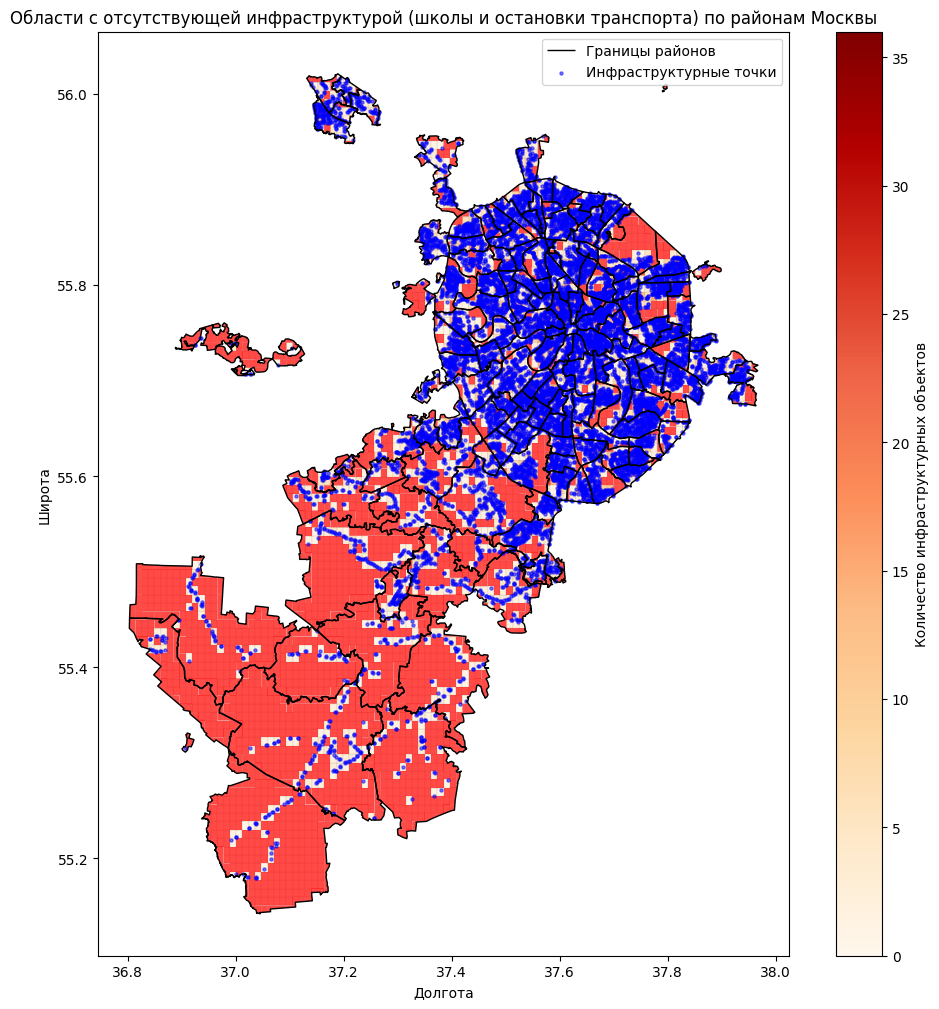

2024-11-10 05:17:45,874 - INFO - Статическая карта создана.
2024-11-10 05:17:45,875 - INFO - Создание интерактивной карты с помощью Folium...
2024-11-10 05:18:04,365 - INFO - Интерактивная карта сохранена в infra_missing_heatmap_limited.html.
2024-11-10 05:18:04,368 - INFO - Начало анализа покрытия с помощью буферов...
2024-11-10 05:18:04,369 - INFO - CRS географическая. Проекция в метрическую систему координат (EPSG:3857)...
2024-11-10 05:18:04,423 - INFO - Проекция выполнена.
2024-11-10 05:18:04,424 - INFO - Создание буферов радиусом 500 метров вокруг каждой точки...
2024-11-10 05:18:04,615 - INFO - Объединение всех буферов в одну геометрию покрытия...
2024-11-10 05:18:06,050 - INFO - Идентификация ячеек сетки, не покрытых буферами...
2024-11-10 05:19:18,777 - INFO - Количество ячеек без покрытия буферами: 2098
2024-11-10 05:19:18,790 - INFO - Создание визуализации покрытия буферами...


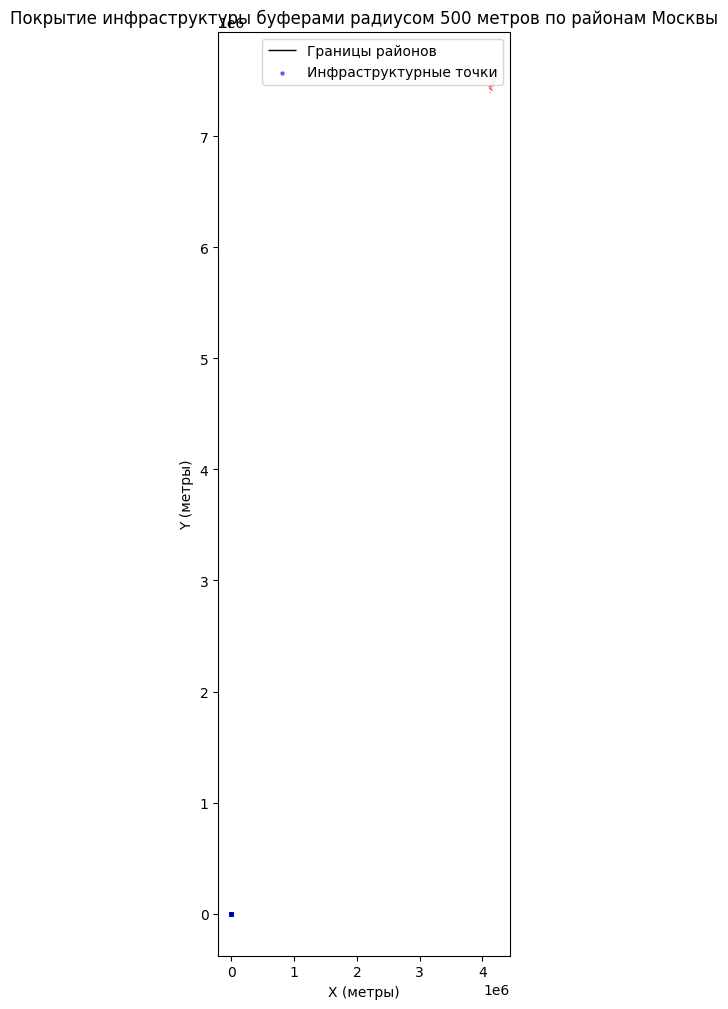

2024-11-10 05:19:19,636 - INFO - Визуализация покрытия буферами создана.


In [3]:
import re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from itertools import product
import numpy as np
import folium
from folium.plugins import MarkerCluster, HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from typing import Tuple

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_geospatial_data(buildings_path: str, boundary_path: str, transport_path: str) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Загружает геопространственные данные из указанных путей к файлам.
    
    Аргументы:
        buildings_path (str): Путь к GeoPackage с полигонами зданий.
        boundary_path (str): Путь к GeoPackage с полигонами границ.
        transport_path (str): Путь к GeoPackage с точками общественного транспорта.
        
    Возвращает:
        Кортеж, содержащий GeoDataFrame для зданий, границ и транспортных остановок.
    """
    logging.info("Загрузка геопространственных данных...")
    buildings = gpd.read_file(buildings_path)
    boundary = gpd.read_file(boundary_path)
    transport = gpd.read_file(transport_path)
    logging.info("Геопространственные данные успешно загружены.")
    return buildings, boundary, transport

def clean_text(series: pd.Series) -> pd.Series:
    """
    Очищает текстовые данные, убирая лишние символы и приводя текст к нижнему регистру.
    
    Аргументы:
        series (pd.Series): Серия pandas с текстовыми данными.
        
    Возвращает:
        pd.Series: Очищенные текстовые данные.
    """
    logging.debug("Очистка текстовых данных...")
    cleaned = series.astype(str).str.strip().str.lower().str.replace(r'[^a-zа-яё\s]', '', regex=True)
    logging.debug("Текстовые данные очищены.")
    return cleaned

def load_population_data(population_path: str) -> pd.DataFrame:
    """
    Загружает и предобрабатывает данные о населении из Excel файла.
    
    Аргументы:
        population_path (str): Путь к Excel файлу с данными о населении.
        
    Возвращает:
        pd.DataFrame: Предобработанные данные о населении.
    """
    logging.info("Загрузка данных о населении...")
    data = pd.read_excel(population_path)
    data["district"] = clean_text(data["district"])
    logging.info("Данные о населении загружены и очищены.")
    return data

def preprocess_boundary(boundary_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Предобрабатывает GeoDataFrame с границами, переименовывая и очищая названия районов.
    
    Аргументы:
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с данными о границах.
        
    Возвращает:
        gpd.GeoDataFrame: Предобработанные данные о границах.
    """
    logging.info("Предобработка данных о границах...")
    boundary_gdf['NAME'] = boundary_gdf['NAME'].str.replace('район', '', regex=False)
    boundary_gdf = boundary_gdf.rename(columns={'NAME': 'district'})
    boundary_gdf['district'] = boundary_gdf['district'].str.lower()
    boundary_gdf['district'] = clean_text(boundary_gdf['district'])
    logging.info("Данные о границах предобработаны.")
    return boundary_gdf

def analyze_population_change(data: pd.DataFrame, boundary_gdf: gpd.GeoDataFrame, population_year: int = 2024) -> gpd.GeoDataFrame:
    """
    Анализирует изменение населения и объединяет данные с GeoDataFrame границ.
    
    Аргументы:
        data (pd.DataFrame): Данные о населении.
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с границами.
        population_year (int): Год для данных о населении (по умолчанию 2024).
        
    Возвращает:
        gpd.GeoDataFrame: Объединенный GeoDataFrame с данными о населении.
    """
    logging.info("Анализ изменения населения...")
    if population_year not in data.columns:
        raise ValueError(f"Год {population_year} не найден в столбцах данных о населении.")
    
    data['people'] = data[population_year]
    merged_gdf = boundary_gdf.merge(data[['district', 'people']], on='district', how='left')
    merged_gdf['people'] = merged_gdf['people'].fillna(0)
    logging.info("Анализ изменения населения завершен.")
    return merged_gdf

def spatial_join_buildings(merged_gdf: gpd.GeoDataFrame, buildings_gdf: gpd.GeoDataFrame, building_type: str = "school") -> gpd.GeoDataFrame:
    """
    Выполняет пространственное объединение между зданиями и границами, фильтруя по типу здания.
    
    Аргументы:
        merged_gdf (gpd.GeoDataFrame): GeoDataFrame с объединенными данными о населении и границах.
        buildings_gdf (gpd.GeoDataFrame): GeoDataFrame с полигонами зданий.
        building_type (str): Тип здания для фильтрации (по умолчанию "school").
        
    Возвращает:
        gpd.GeoDataFrame: GeoDataFrame отфильтрованных зданий внутри районов.
    """
    logging.info(f"Выполнение пространственного объединения для зданий типа '{building_type}'...")
    buildings_with_district = gpd.sjoin(buildings_gdf, merged_gdf, how="left", predicate='within')
    filtered_buildings = buildings_with_district[buildings_with_district["BUILDING"] == building_type][["people", "district", "geometry"]]
    logging.info(f"Пространственное объединение завершено. Количество зданий типа '{building_type}': {len(filtered_buildings)}")
    return filtered_buildings

def convert_to_points(buildings_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Преобразует геометрию зданий в точки (центроиды).
    
    Аргументы:
        buildings_gdf (gpd.GeoDataFrame): GeoDataFrame с полигонами зданий.
        
    Возвращает:
        gpd.GeoDataFrame: GeoDataFrame с точечной геометрией.
    """
    logging.info("Преобразование геометрии зданий в точки (центроиды)...")
    buildings_gdf['geometry'] = buildings_gdf.geometry.centroid
    points_gdf = buildings_gdf.copy()
    points_gdf = gpd.GeoDataFrame(points_gdf, geometry='geometry')
    logging.info(f"Преобразование завершено. Количество точек: {len(points_gdf)}")
    return points_gdf

def merge_infrastructure(schools_gdf: gpd.GeoDataFrame, transport_gdf: gpd.GeoDataFrame, target_crs: str) -> gpd.GeoDataFrame:
    """
    Объединяет точки школ и остановок транспорта в один GeoDataFrame.
    
    Аргументы:
        schools_gdf (gpd.GeoDataFrame): GeoDataFrame с точками школ.
        transport_gdf (gpd.GeoDataFrame): GeoDataFrame с точками остановок транспорта.
        target_crs (str): Целевая система координат.
        
    Возвращает:
        gpd.GeoDataFrame: Объединенный GeoDataFrame с инфраструктурными точками.
    """
    logging.info("Объединение точек школ и остановок транспорта...")
    schools_gdf['type'] = 'school'
    transport_gdf['type'] = 'transport_stop'
    
    # Выбор необходимых столбцов
    schools_selected = schools_gdf[['type', 'geometry']]
    transport_selected = transport_gdf[['type', 'geometry']]
    
    # Обеспечение согласованности CRS
    if schools_selected.crs != target_crs:
        logging.info("Преобразование CRS школ к целевому CRS...")
        schools_selected = schools_selected.to_crs(target_crs)
    if transport_selected.crs != target_crs:
        logging.info("Преобразование CRS транспорта к целевому CRS...")
        transport_selected = transport_selected.to_crs(target_crs)
    
    # Объединение данных
    combined_points = pd.concat([schools_selected, transport_selected], ignore_index=True)
    combined_gdf = gpd.GeoDataFrame(combined_points, geometry='geometry', crs=target_crs)
    logging.info("Инфраструктурные точки успешно объединены.")
    return combined_gdf

def create_grid(boundary_gdf: gpd.GeoDataFrame, grid_size: int = 100) -> gpd.GeoDataFrame:
    """
    Создает сетку (Grid) поверх области интереса.
    
    Аргументы:
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с полигонами границ.
        grid_size (int): Количество ячеек по одной оси (по умолчанию 100).
        
    Возвращает:
        gpd.GeoDataFrame: GeoDataFrame с ячейками сетки.
    """
    logging.info("Создание сетки поверх области границ...")
    all_districts = unary_union(boundary_gdf.geometry)
    xmin, ymin, xmax, ymax = all_districts.bounds
    logging.debug(f"Границы области: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")
    
    x_edges = np.linspace(xmin, xmax, grid_size + 1)
    y_edges = np.linspace(ymin, ymax, grid_size + 1)
    
    grid_cells = [
        Polygon([
            (x_edges[x], y_edges[y]),
            (x_edges[x+1], y_edges[y]),
            (x_edges[x+1], y_edges[y+1]),
            (x_edges[x], y_edges[y+1]),
            (x_edges[x], y_edges[y])
        ])
        for x, y in product(range(grid_size), range(grid_size))
    ]
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells})
    grid.crs = boundary_gdf.crs
    logging.info(f"Сетка создана с {len(grid)} ячейками.")
    
    # Обрезка сетки по границам районов
    logging.info("Обрезка сетки по границам районов...")
    grid = gpd.overlay(grid, boundary_gdf, how='intersection')
    logging.info(f"Сетка после обрезки: {len(grid)} ячеек.")
    return grid

def count_infrastructure(grid: gpd.GeoDataFrame, infrastructure_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Подсчитывает количество инфраструктурных точек в каждой ячейке сетки.
    
    Аргументы:
        grid (gpd.GeoDataFrame): GeoDataFrame с ячейками сетки.
        infrastructure_gdf (gpd.GeoDataFrame): GeoDataFrame с инфраструктурными точками.
        
    Возвращает:
        gpd.GeoDataFrame: GeoDataFrame с добавленным столбцом 'count'.
    """
    logging.info("Подсчет инфраструктурных точек в каждой ячейке сетки...")
    grid['count'] = grid.geometry.apply(lambda cell: infrastructure_gdf.within(cell).sum())
    logging.info("Подсчет инфраструктуры завершен.")
    return grid

def identify_missing_infrastructure(grid: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Идентифицирует ячейки сетки без инфраструктуры.
    
    Аргументы:
        grid (gpd.GeoDataFrame): GeoDataFrame с подсчитанным количеством инфраструктуры.
        
    Возвращает:
        gpd.GeoDataFrame: GeoDataFrame ячеек без инфраструктуры.
    """
    logging.info("Идентификация ячеек без инфраструктуры...")
    no_infra = grid[grid['count'] == 0]
    logging.info(f"Найдено {len(no_infra)} ячеек без инфраструктуры.")
    return no_infra

def visualize_static_map(grid: gpd.GeoDataFrame, no_infra: gpd.GeoDataFrame, boundary_gdf: gpd.GeoDataFrame, infrastructure_gdf: gpd.GeoDataFrame) -> None:
    """
    Создает статическую карту, визуализирующую распределение инфраструктуры и отсутствующие области.
    
    Аргументы:
        grid (gpd.GeoDataFrame): GeoDataFrame с подсчитанным количеством инфраструктуры.
        no_infra (gpd.GeoDataFrame): GeoDataFrame ячеек без инфраструктуры.
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с границами.
        infrastructure_gdf (gpd.GeoDataFrame): GeoDataFrame с инфраструктурными точками.
    """
    logging.info("Создание статической визуализации карты...")
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Отображение сетки с подсчетом инфраструктуры
    grid.plot(column='count', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='grey', legend=True, 
              legend_kwds={'label': "Количество инфраструктурных объектов", 'orientation': "vertical"})
    
    # Выделение ячеек без инфраструктуры
    no_infra.plot(ax=ax, color='red', alpha=0.7, label='Нет инфраструктуры')
    
    # Отображение границ районов
    boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=1, label='Границы районов')
    
    # Отображение инфраструктурных точек
    infrastructure_gdf.plot(ax=ax, markersize=5, alpha=0.5, color='blue', label='Инфраструктурные точки')
    
    # Настройка отображения
    ax.set_title('Области с отсутствующей инфраструктурой (школы и остановки транспорта) по районам Москвы')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.legend()
    plt.show()
    logging.info("Статическая карта создана.")

def visualize_interactive_map(combined_gdf: gpd.GeoDataFrame, no_infra: gpd.GeoDataFrame, boundary_gdf: gpd.GeoDataFrame, district_field: str, output_path: str = 'infra_missing_heatmap_limited.html') -> None:
    """
    Создает интерактивную карту с помощью Folium, отображающую инфраструктуру и отсутствующие области.
    
    Аргументы:
        combined_gdf (gpd.GeoDataFrame): Объединенный GeoDataFrame с инфраструктурными точками.
        no_infra (gpd.GeoDataFrame): GeoDataFrame ячеек без инфраструктуры.
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с границами.
        district_field (str): Имя поля для названий районов.
        output_path (str): Путь для сохранения HTML файла с картой (по умолчанию 'infra_missing_heatmap_limited.html').
    """
    logging.info("Создание интерактивной карты с помощью Folium...")
    
    # Инициализация карты Folium, центрированной на Москве
    m = folium.Map(location=[55.7558, 37.6173], zoom_start=10)
    
    # Добавление слоя HeatMap для отображения плотности инфраструктуры
    heat_data = [[point.y, point.x] for point in combined_gdf.geometry]
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)
    
    # Добавление ячеек без инфраструктуры красным цветом
    for _, row in no_infra.iterrows():
        sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        folium.GeoJson(
            data=geo_j,
            style_function=lambda x: {
                'fillColor': 'red',
                'color': 'red',
                'fillOpacity': 0.6,
                'weight': 0,
            },
            tooltip='Нет инфраструктуры'
        ).add_to(m)
    
    # Добавление кластеров точек инфраструктуры
    marker_cluster = MarkerCluster().add_to(m)
    for _, row in combined_gdf.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x], 
            popup=row['type']
        ).add_to(marker_cluster)
    
    # Добавление границ районов
    boundary_gdf_geo = boundary_gdf.to_crs(epsg=4326).to_json()
    folium.GeoJson(
        data=boundary_gdf_geo,
        style_function=lambda x: {
            'fillColor': 'none',
            'color': 'black',
            'weight': 2,
        },
        tooltip=folium.GeoJsonTooltip(fields=[district_field], aliases=['Район:'])
    ).add_to(m)
    
    # Ограничение отображения карты границами районов
    bounds = boundary_gdf.total_bounds  # [minx, miny, maxx, maxy]
    m.fit_bounds([
        [bounds[1], bounds[0]],
        [bounds[3], bounds[2]]
    ])
    
    # Сохранение карты в HTML файл
    m.save(output_path)
    logging.info(f"Интерактивная карта сохранена в {output_path}.")

def perform_buffer_analysis(infrastructure_gdf: gpd.GeoDataFrame, boundary_gdf: gpd.GeoDataFrame, grid: gpd.GeoDataFrame, buffer_distance: float = 500) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Выполняет анализ покрытия с помощью буферов для определения областей без покрытия инфраструктурой.
    
    Аргументы:
        infrastructure_gdf (gpd.GeoDataFrame): GeoDataFrame с инфраструктурными точками.
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с границами.
        grid (gpd.GeoDataFrame): GeoDataFrame с сеткой.
        buffer_distance (float): Радиус буфера в метрах (по умолчанию 500).
        
    Возвращает:
        Кортеж, содержащий GeoDataFrame покрытия и GeoDataFrame ячеек без покрытия.
    """
    logging.info("Начало анализа покрытия с помощью буферов...")
    
    # Проверка CRS на метрическую проекцию
    if infrastructure_gdf.crs.is_geographic:
        logging.info("CRS географическая. Проекция в метрическую систему координат (EPSG:3857)...")
        infrastructure_gdf = infrastructure_gdf.to_crs(epsg=3857)
        boundary_gdf = boundary_gdf.to_crs(epsg=3857)
        grid = grid.to_crs(epsg=3857)
        logging.info("Проекция выполнена.")
    else:
        logging.info("CRS метрическая. Продолжаем.")
    
    # Создание буферов вокруг инфраструктурных точек
    logging.info(f"Создание буферов радиусом {buffer_distance} метров вокруг каждой точки...")
    buffers = infrastructure_gdf.geometry.buffer(buffer_distance)
    
    # Объединение всех буферов в одну геометрию покрытия
    logging.info("Объединение всех буферов в одну геометрию покрытия...")
    coverage = unary_union(buffers)
    
    # Создание GeoDataFrame для покрытия
    coverage_gdf = gpd.GeoDataFrame({'geometry': [coverage]}, crs=infrastructure_gdf.crs)
    
    # Идентификация ячеек сетки, не покрытых буферами
    logging.info("Идентификация ячеек сетки, не покрытых буферами...")
    grid['covered'] = grid.geometry.intersects(coverage)
    uncovered = grid[~grid['covered']]
    logging.info(f"Количество ячеек без покрытия буферами: {len(uncovered)}")
    
    return coverage_gdf, uncovered

def visualize_buffer_coverage(coverage_gdf: gpd.GeoDataFrame, uncovered: gpd.GeoDataFrame, infrastructure_gdf: gpd.GeoDataFrame, boundary_gdf: gpd.GeoDataFrame, buffer_distance: float) -> None:
    """
    Визуализирует покрытие буферами и ячейки без покрытия на статической карте.
    
    Аргументы:
        coverage_gdf (gpd.GeoDataFrame): GeoDataFrame, представляющий покрытие буферами.
        uncovered (gpd.GeoDataFrame): GeoDataFrame ячеек без покрытия.
        infrastructure_gdf (gpd.GeoDataFrame): GeoDataFrame с инфраструктурными точками.
        boundary_gdf (gpd.GeoDataFrame): GeoDataFrame с границами.
        buffer_distance (float): Радиус буфера в метрах.
    """
    logging.info("Создание визуализации покрытия буферами...")
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Отображение области покрытия
    coverage_gdf.plot(ax=ax, color='green', alpha=0.3, label='Покрытие буферами')
    
    # Отображение сетки
    boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=1, label='Границы районов')
    uncovered.plot(ax=ax, color='red', alpha=0.5, label='Без покрытия буферами')
    
    # Отображение инфраструктурных точек
    infrastructure_gdf.plot(ax=ax, markersize=5, alpha=0.5, color='blue', label='Инфраструктурные точки')
    
    # Настройка отображения
    ax.set_title(f'Покрытие инфраструктуры буферами радиусом {buffer_distance} метров по районам Москвы')
    plt.xlabel('X (метры)')
    plt.ylabel('Y (метры)')
    plt.legend()
    plt.show()
    logging.info("Визуализация покрытия буферами создана.")

def main(
    buildings_path: str,
    boundary_path: str,
    transport_path: str,
    population_path: str,
    population_year: int = 2024,
    building_type: str = "school",
    grid_size: int = 100,
    buffer_distance: float = 500,
    district_field: str = 'district',
    interactive_map_path: str = 'infra_missing_heatmap_limited.html'
) -> None:
    """
    Основная функция для выполнения рабочего процесса анализа инфраструктуры.
    
    Аргументы:
        buildings_path (str): Путь к GeoPackage с полигонами зданий.
        boundary_path (str): Путь к GeoPackage с полигонами границ.
        transport_path (str): Путь к GeoPackage с точками общественного транспорта.
        population_path (str): Путь к Excel файлу с данными о населении.
        population_year (int): Год для данных о населении (по умолчанию 2024).
        building_type (str): Тип здания для анализа (по умолчанию "school").
        grid_size (int): Размер сетки для пространственного анализа (по умолчанию 100).
        buffer_distance (float): Расстояние буфера в метрах для анализа покрытия (по умолчанию 500).
        district_field (str): Имя поля для названий районов в GeoDataFrame границ (по умолчанию 'district').
        interactive_map_path (str): Путь для сохранения интерактивной карты Folium (по умолчанию 'infra_missing_heatmap_limited.html').
    """
    # Подавление предупреждений
    warnings.filterwarnings('ignore')
    
    # Загрузка данных
    buildings, boundary, transport = load_geospatial_data(buildings_path, boundary_path, transport_path)
    population_data = load_population_data(population_path)
    
    # Предобработка данных о границах
    boundary = preprocess_boundary(boundary)
    
    # Анализ изменения населения
    merged_gdf = analyze_population_change(population_data, boundary, population_year)
    
    # Пространственное объединение для зданий
    buildings_filtered = spatial_join_buildings(merged_gdf, buildings, building_type)
    
    # Преобразование геометрии зданий в точки
    schools_points = convert_to_points(buildings_filtered)
    
    # Объединение инфраструктурных точек
    combined_infra = merge_infrastructure(schools_points, transport, target_crs=boundary.crs)
    
    logging.info(f"Общее количество инфраструктурных точек: {len(combined_infra)}")
    
    # Создание сетки
    grid = create_grid(boundary, grid_size)
    
    # Подсчет инфраструктуры в каждой ячейке сетки
    grid = count_infrastructure(grid, combined_infra)
    
    # Идентификация ячеек без инфраструктуры
    no_infra = identify_missing_infrastructure(grid)
    
    # Визуализация статической карты









    
    visualize_static_map(grid, no_infra, boundary, combined_infra)
    
    # Визуализация интерактивной карты
    visualize_interactive_map(combined_infra, no_infra, boundary, district_field, interactive_map_path)
    
    # Опционально: Анализ покрытия буферами
    coverage_gdf, uncovered = perform_buffer_analysis(combined_infra, boundary, grid, buffer_distance)
    visualize_buffer_coverage(coverage_gdf, uncovered, combined_infra, boundary, buffer_distance)

if __name__ == "__main__":
    # Определение путей к файлам
    BUILDINGS_PATH = 'msk/data/building-polygon.gpkg'
    BOUNDARY_PATH = 'msk/data/boundary-polygon-lvl8.gpkg'
    TRANSPORT_PATH = 'msk/data/public-transport-point.gpkg'
    POPULATION_PATH = 'population.xlsx'
    
    # Выполнение основного рабочего процесса
    main(
        buildings_path=BUILDINGS_PATH,
        boundary_path=BOUNDARY_PATH,
        transport_path=TRANSPORT_PATH,
        population_path=POPULATION_PATH,
        population_year=2024,
        building_type="school",
        grid_size=100,
        buffer_distance=500,
        district_field='district',
        interactive_map_path='infra_missing_heatmap_limited.html'
    )


In [2]:
m

NameError: name 'm' is not defined